In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, normaltest, shapiro
from scipy.stats import t as t_fun
from sklearn.model_selection import train_test_split

## Wire Bond

In [2]:
dataset = pd.read_csv("../data/montgomery/wire_bond.txt", sep=" ", index_col=0)
dataset.head()

,Wire_Length,Die_Heigh,Pull_Strength
Index,,,
1,2,50,9.95
2,8,110,24.45
3,11,120,31.75
4,10,550,35.00
5,8,295,25.02


In [3]:
dataset.corr()

,Wire_Length,Die_Heigh,Pull_Strength
Wire_Length,1.000000,0.378413,0.981812
Die_Heigh,0.378413,1.000000,0.492867
Pull_Strength,0.981812,0.492867,1.000000


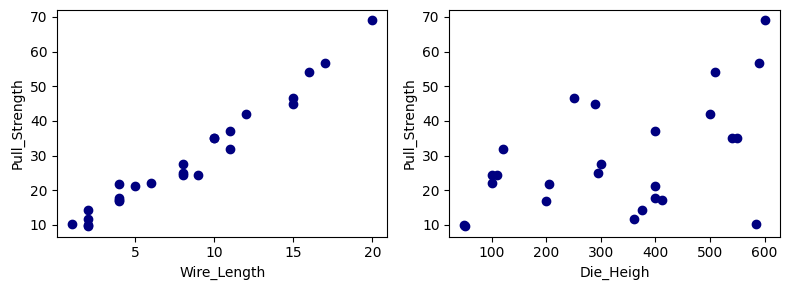

In [4]:
cols = ["Wire_Length", "Die_Heigh"]

fig, ax = plt.subplots(1, 2, figsize=[8, 3], dpi=100)

fig.patch.set_facecolor('white')

for j, col in enumerate(cols):
    ax[j].scatter(dataset[col], dataset["Pull_Strength"], color="navy")
    ax[j].set_xlabel(col)
    ax[j].set_ylabel("Pull_Strength")
fig.tight_layout()

plt.show()

## Linear Regression

$$
y_i = \beta_0 + \sum_{j=1}^M \beta_j x_{i, j} + \epsilon_{i}
$$

$$
\boldsymbol{y} = \beta_0 + \boldsymbol{X} \boldsymbol{\beta} + \boldsymbol{\epsilon}
$$

$$
\boldsymbol{C} = (\boldsymbol{X}^T \boldsymbol{X}) ^ {-1}
$$

$$
\hat{\boldsymbol{\beta}} = \boldsymbol{C} \cdot (\boldsymbol{X}^T \boldsymbol{y})
$$

$$
\hat{y_i} = \beta_0 + \sum_{j=1}^M \beta_j x_{i, j}
$$

$$
SS_e = \sum_{i=1}^N (y_i - \beta_0 + \sum_{j=1}^M \beta_j x_{i, j}) ^ 2
$$

$$
\hat{\sigma} ^ 2 = SS_e / (N - p)
$$

$$
\boldsymbol{V} = \hat{\sigma} ^ 2 \boldsymbol{C}
$$

$$
\sigma_{\hat{\beta_{j}}} = \sqrt{v_{j, j}}
$$

$$
\hat{\mu}_{y|{\boldsymbol{x}_0}} \pm t_{\alpha / 2, n-p} \sqrt{\hat{\sigma} ^ 2 \boldsymbol{x}_0 ^ T \boldsymbol{C} \boldsymbol{x}_0}
$$

In [5]:
class LinearRegression:
    
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept
    
    def fit(self, X, y=None):
        
        X = self._prepare_X(X)
        n, p = X.shape
        
        self.n = n
        self.p = p
        
        C = np.linalg.inv(X.T.dot(X))
        self.C = C

        betas = C.dot(X.T.dot(y))
        self.betas = betas
        
        epsilon = y - X.dot(betas)
        sse = np.sum(epsilon * epsilon)
        
        sigma_squared = sse / (n - p)
        self.sigma_squared = sigma_squared
        
        sigma = np.sqrt(sigma_squared)
        self.sigma = sigma
        
        V = C * sigma_squared
        self.V = V

        sigma_betas = np.sqrt(np.diag(V))
        self.sigma_betas = sigma_betas
        
        pvalues = t_fun.sf(abs(betas) / sigma_betas, (n - p)) * 2.0
        self.pvalues = pvalues
    
    def predict(self, X, y=None):
        X = self._prepare_X(X)
        y_pred = X.dot(self.betas)
        return y_pred
    
    def fit_predict(self, X, y=None):
        self.fit(X, y)
        y_pred = self.predict(X)
        return y_pred
    
    def predict_confidence_interval(self, X, alpha=0.05):
        X = self._prepare_X(X)
        t_value = t_fun.isf(alpha/2, self.n - self.p)
        sigma_pred = np.sqrt(self.sigma_squared * np.sum(X.dot(self.C) * X, axis=1))
        return t_value * sigma_pred
    
    def _prepare_X(self, X):
        
        X = np.array(X)
        if len(X.shape) == 1:
            X = np.atleast_2d(X).reshape((-1, 1))
        
        if self.fit_intercept:
            ones = np.ones((X.shape[0], 1))
            X = np.column_stack((ones, X))
        
        else:
            pass

        return X
    
    def r2_score(self, X, y):
        
        y_pred = self.predict(X)
        epsilon = y_pred - y
        sse = np.sum(epsilon * epsilon)
        
        y_mean = np.mean(y)
        mean_res = y_mean - y
        sst = np.sum(mean_res * mean_res)
        
        return 1 - sse / sst

## Original problem

In [6]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

In [7]:
linreg = LinearRegression()
linreg.fit(X, y)
print(linreg.r2_score(X, y))

0.9811374834912948


In [8]:
for i, val in enumerate(linreg.betas):
    pval = linreg.pvalues[i]
    print(f"Beta {i}: {val:.2f}; p-value: {pval:.2f}")

Beta 0: 2.26; p-value: 0.04
Beta 1: 2.74; p-value: 0.00
Beta 2: 0.01; p-value: 0.00


### Model adequacy

In [9]:
y_hat = linreg.predict(X)
epsilon = y - y_hat
print(f"Mean epsilon: {np.mean(epsilon):.3f}")
print(f"Sigma epsilon: {np.std(epsilon):.3f}")

Mean epsilon: -0.000
Sigma epsilon: 2.146


In [10]:
shapiro_stat, shapiro_pvalue = shapiro(epsilon)
print(f"Shapiro test p-value: {shapiro_pvalue:.2f}")

Shapiro test p-value: 0.38


In [11]:
normal_stat, normal_pvalue = normaltest(epsilon)
print(f"Normal test p-value: {normal_pvalue:.2f}")

Normal test p-value: 0.10


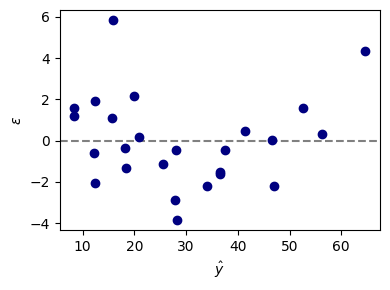

In [12]:
fig, ax = plt.subplots(figsize=[4, 3], dpi=100)

fig.patch.set_facecolor('white')

ax.scatter(y_hat, epsilon, color="navy", zorder=1)
ax.set_xlabel(r"$\hat{y}$")
ax.set_ylabel(r"$\epsilon$")
ax.axhline(y=0.0, color='grey', linestyle='--', zorder=0)
fig.tight_layout()

plt.show()

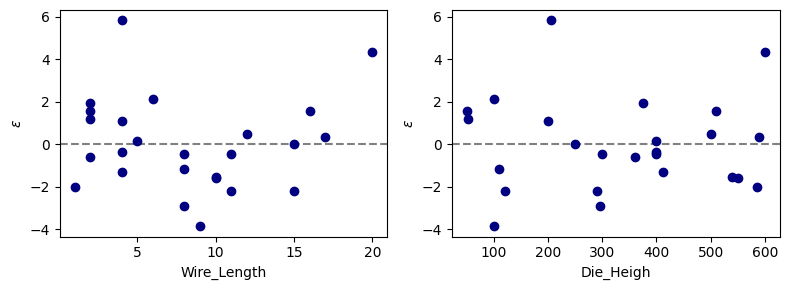

In [13]:
cols = ["Wire_Length", "Die_Heigh"]

fig, ax = plt.subplots(1, 2, figsize=[8, 3], dpi=100)

fig.patch.set_facecolor('white')

for j, col in enumerate(cols):
    ax[j].scatter(X[:, j], epsilon, color="navy", zorder=1)
    ax[j].set_xlabel(col)
    ax[j].set_ylabel(r"$\epsilon$")
    ax[j].axhline(y=0.0, color='grey', linestyle='--', zorder=0)
fig.tight_layout()

plt.show()

### Confidence interval example

In [14]:
# Given x0 from Montgomery
x0 = np.atleast_2d([8.0, 275.0])
y_x0 = linreg.predict(x0)
ci_x0 = linreg.predict_confidence_interval(x0, alpha=0.05)
y_range_x0 = (y_x0 - ci_x0)[0], (y_x0 + ci_x0)[0]
print(f"{y_range_x0[0]:.2f} ≤ {y_x0[0]:.2f} ≤ {y_range_x0[1]:.2f}")

26.66 ≤ 27.66 ≤ 28.66


## False predictor

In [15]:
np.random.seed(42)
x_false = X[:, 0] + np.random.randn(X.shape[0])
X_false = np.column_stack((X, x_false.reshape((-1, 1))))

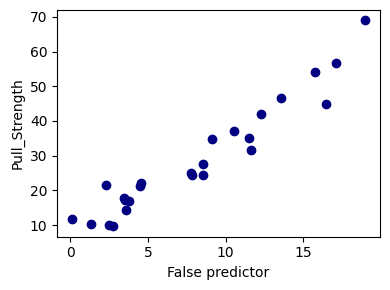

In [16]:
fig, ax = plt.subplots(figsize=[4, 3], dpi=100)
fig.patch.set_facecolor('white')
ax.scatter(x_false, dataset["Pull_Strength"], color="navy")
ax.set_xlabel("False predictor")
ax.set_ylabel("Pull_Strength")
fig.tight_layout()

plt.show()

In [17]:
linreg_alt = LinearRegression()
linreg_alt.fit(X_false, y)
print(linreg_alt.r2_score(X_false, y))

0.9828394023241431


In [18]:
for i, val in enumerate(linreg_alt.betas):
    pval = linreg_alt.pvalues[i]
    print(f"Beta {i}: {val:.2f}; p-value: {pval:.2f}")

Beta 0: 2.13; p-value: 0.05
Beta 1: 3.43; p-value: 0.00
Beta 2: 0.01; p-value: 0.00
Beta 3: -0.69; p-value: 0.16


## Oil pitch

In [19]:
dataset = pd.read_csv("../data/montgomery/oil_pitch.txt", sep=" ", index_col=0)
dataset.head()

,Temp,Soaktime,Soakpct,Difftime,Diffpct,Pitch
Index,,,,,,
0,1650,0.58,1.10,0.25,0.90,0.013
1,1650,0.66,1.10,0.33,0.90,0.016
2,1650,0.66,1.10,0.33,0.90,0.015
3,1650,0.66,1.10,0.33,0.95,0.016
4,1600,0.66,1.15,0.33,1.00,0.015


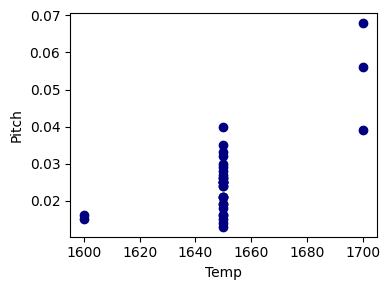

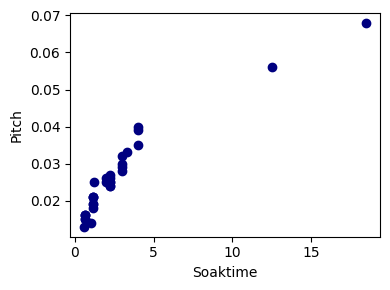

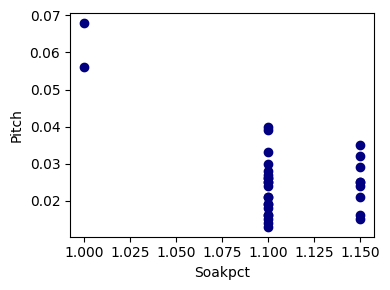

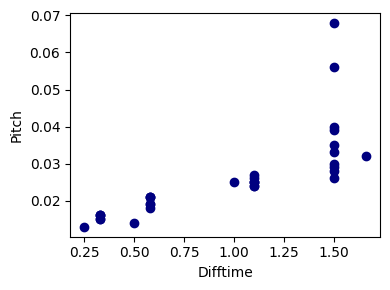

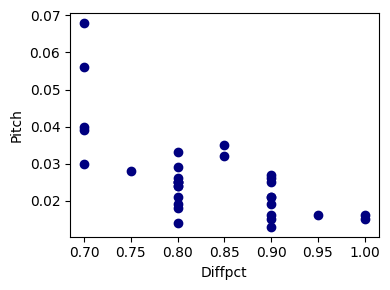

In [20]:
for col in ['Temp', 'Soaktime', 'Soakpct', 'Difftime', 'Diffpct']:

    fig, ax = plt.subplots(figsize=[4, 3], dpi=100)
    ax.scatter(dataset[col], dataset["Pitch"], color="navy")
    ax.set_xlabel(col)
    ax.set_ylabel("Pitch")
    fig.tight_layout()

    plt.show()

In [21]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

In [22]:
linreg = LinearRegression()
linreg.fit(X, y)
print(linreg.r2_score(X, y))

0.9689792908820654


In [23]:
for i, val in enumerate(linreg.betas):
    pval = linreg.pvalues[i]
    print(f"Beta {i}: {val:.2f}; p-value: {pval:.2f}")

Beta 0: -0.08; p-value: 0.30
Beta 1: 0.00; p-value: 0.24
Beta 2: 0.00; p-value: 0.00
Beta 3: 0.02; p-value: 0.37
Beta 4: 0.01; p-value: 0.00
Beta 5: -0.00; p-value: 0.70


### Benchmark

In [24]:
import statsmodels.api as sm

In [25]:
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()

In [26]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     162.4
Date:                Fri, 02 Sep 2022   Prob (F-statistic):           9.54e-19
Time:                        23:12:12   Log-Likelihood:                 152.70
No. Observations:                  32   AIC:                            -293.4
Df Residuals:                      26   BIC:                            -284.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0784      0.074     -1.065      0.2

## Diabetes

In [27]:
diabetes = pd.read_csv("../data/diabetes.txt", index_col=0)
diabetes.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,glu
Index,,,,,,,,,,,
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


In [28]:
diabetes.shape

(442, 11)

In [29]:
X = diabetes.iloc[:, :-1].values
y = diabetes.iloc[:, -1].values

### Direct procedure

In [30]:
training_samples = 400

X_train = X[:training_samples, :].copy()
X_test = X[training_samples:, :].copy()

y_train = y[:training_samples].copy()
y_test = y[training_samples:].copy()

In [31]:
print("Verifying if distributions correspond")
print("Train")
print("Mean")
print(X_train.mean(axis=0))
print("Std")
print(X_train.std(axis=0))

print("\nTest")
print("Mean")
print(X_test.mean(axis=0))
print("Std")
print(X_test.std(axis=0))

Verifying if distributions correspond
Train
Mean
[ 6.90346674e-06  8.74501623e-04 -4.39659541e-04  9.05002451e-05
 -6.84910109e-04 -9.59628229e-04 -3.11877202e-04 -1.75238581e-04
  4.40114081e-04 -8.91302689e-04]
Std
[0.04785924 0.0476126  0.04682002 0.04686824 0.04728375 0.04708328
 0.04708473 0.04761204 0.04813429 0.04755817]

Test
Mean
[-6.57473023e-05 -8.32858689e-03  4.18723372e-03 -8.61907096e-04
  6.52295342e-03  9.13931646e-03  2.97025907e-03  1.66893886e-03
 -4.19156267e-03  8.48859704e-03]
Std
[0.04466728 0.04629024 0.05397103 0.05374384 0.0496953  0.05103441
 0.05182429 0.04708357 0.04152469 0.04678833]


In [32]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

print(f"Train score: {linreg.r2_score(X_train, y_train):.3f}")
print(f"Test score: {linreg.r2_score(X_test, y_test):.2f}")

Train score: 0.499
Test score: 0.70


In [33]:
for i, val in enumerate(linreg.betas):
    pval = linreg.pvalues[i]
    print(f"Beta {i}: {val:.2f}; p-value: {pval:.2f}")

Beta 0: 152.73; p-value: 0.00
Beta 1: 5.03; p-value: 0.94
Beta 2: -238.41; p-value: 0.00
Beta 3: 521.64; p-value: 0.00
Beta 4: 299.93; p-value: 0.00
Beta 5: -752.09; p-value: 0.08
Beta 6: 445.12; p-value: 0.21
Beta 7: 83.50; p-value: 0.71
Beta 8: 185.57; p-value: 0.28
Beta 9: 706.46; p-value: 0.00
Beta 10: 88.69; p-value: 0.22


### Backward Feature Elimination based on p-values

In [34]:
class LinearBFE:
    
    def __init__(self, alpha=0.05, fit_intercept=True, original_cols=None, verbose=False):
        
        self.alpha = 0.05
        self.fit_intercept = fit_intercept
        self.index_cols = None
        self.original_cols = original_cols
        self.verbose = verbose
    
    def fit(self, X, y=None):
        
        X = np.array(X)
        y = np.array(y)
        
        self.index_cols = np.arange(X.shape[1])
        
        if self.original_cols is None:
            self.original_cols = self.index_cols.copy()
        
        self.remain_cols = self.original_cols.copy()
        self.keep_ = self.index_cols.copy()
        
        max_iter = X.shape[1]
        if not self.fit_intercept:
            max_iter = max_iter - 1
        
        for _ in range(max_iter):
            
            linreg = LinearRegression(fit_intercept=self.fit_intercept)
            linreg.fit(X, y)
            
            if np.any(linreg.pvalues > 0.05):
                drop_col = np.argmax(linreg.pvalues)
                
                if self.fit_intercept:
                    if (drop_col == 0):
                        self.fit_intercept = False
                        if self.verbose:
                            print(f"Intercept dropped: {linreg.pvalues[0]:.3f}")
                        continue
                    else:
                        x_drop = drop_col - 1
                        
                if self.verbose:
                    print(f"Column dropped: {self.remain_cols[x_drop]} - {linreg.pvalues[drop_col]:.3f}")
                
                X = np.delete(X, x_drop, axis=1)
                self.remain_cols = np.delete(self.remain_cols, x_drop)
                self.keep_ = np.delete(self.keep_, x_drop)
            
            else:
                if self.verbose:
                    print("All remaing are significant")
                self.linreg = linreg
                break
    
    def transform(self, X, y=None):
        X = np.array(X)
        X = X[:, self.keep_]
        return X
    
    def predict(self, X, y=None):
        X = self.transform(X)
        return self.linreg.predict(X)
    
    def fit_predict(self, X, y=None):
        self.fit(X, y)
        return self.predict(X, y)
    
    def r2_score(self, X, y=None):
        X = self.transform(X)
        return self.linreg.r2_score(X, y)

In [35]:
bfe = LinearBFE(alpha=0.01, verbose=True, original_cols=diabetes.columns[:-1])
bfe.fit(X_train, y_train)

Column dropped: age - 0.937
Column dropped: s3 - 0.709
Column dropped: s4 - 0.265
Column dropped: s6 - 0.176
All remaing are significant


In [36]:
print(f"Train score: {bfe.r2_score(X_train, y_train):.3f}")
print(f"Test score: {bfe.r2_score(X_test, y_test):.2f}")

Train score: 0.495
Test score: 0.71


In [37]:
train_scores_raw = []
test_scores_raw = []

train_scores_clean = []
test_scores_clean = []

In [38]:
for seed in range(500):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    
    linreg = LinearRegression(fit_intercept=True)
    linreg.fit(X_train, y_train)
    
    train_scores_raw.append(linreg.r2_score(X_train, y_train))
    test_scores_raw.append(linreg.r2_score(X_test, y_test))
    
    bfe = LinearBFE(alpha=0.01, fit_intercept=True)
    bfe.fit(X_train, y_train)
    
    train_scores_clean.append(bfe.r2_score(X_train, y_train))
    test_scores_clean.append(bfe.r2_score(X_test, y_test))

In [39]:
print(f"No column removal score: {np.mean(test_scores_raw):.3f}")
print(f"Column removal score: {np.mean(test_scores_clean):.3f}")

No column removal score: 0.478
Column removal score: 0.481


In [40]:
from scipy.stats import wilcoxon

In [41]:
wilcoxon(test_scores_raw, test_scores_clean)

WilcoxonResult(statistic=48510.0, pvalue=1.2606674531880719e-05)